In [1]:
import pandas as pd
import numpy as np
import time
from pyecharts import Bar
from scipy import stats,integrate
import matplotlib.pyplot as plt
import lightgbm as lgb
# from sklearn.model_selection import train_test_split
%matplotlib inline

ERROR:lml.utils:failed to import pyecharts_snapshot
Traceback (most recent call last):
  File "C:\Users\seanz\Anaconda3\lib\site-packages\lml\utils.py", line 43, in do_import
    plugin_module = __import__(plugin_module_name)
ModuleNotFoundError: No module named 'pyecharts_snapshot'


KASANDR数据集 (https://www.kesci.com/home/dataset/59fc323aa22c1744773ac65f)

In [20]:
'''start = time.time()
train = pd.read_csv('./train_de.csv',sep='\t')

print(mid-start)
'''
mid = time.time()
test = pd.read_csv('./test_de.csv',sep='\t')
end = time.time()
print(end-mid)

6.002588987350464


In [21]:
len(test)

1919561

- Instances: 15,844,718
- Attributes: 2,299,713
- userid: Categorical, 291,485  ->  用户的唯一标签
- offerid: Categorical, 2,158,859  ->  商品的唯一标签
- countrycode: Categorical, 1 (de - Germany) -> 国家
- category: Integer, 271 -> 商品种类
- merchant: Integer, 703 -> 商家的唯一标签
- utcdate: Timestamp, 2016-06-01 02:00:17.0 to 2016-06-14 23:52:51.0 -> 时间
- implicit feedback (click): Binary, 0 or 1 -> 是否点击

In [12]:
train.head()

,userid,offerid,countrycode,category,merchant,utcdate,rating
0,fa937b779184527f12e2d71c711e6411236d1ab59f8597...,c5f63750c2b5b0166e55511ee878b7a3,de,100020213,f3c93baa0cf4430849611cedb3a40ec4094d1d370be841...,2016-06-14 17:28:47.0,0
1,f6c8958b9bc2d6033ff4c1cc0a03e9ab96df4bcc528913...,19754ec121b3a99fff3967646942de67,de,100020213,21a509189fb0875c3732590121ff3fc86da770b0628c18...,2016-06-14 17:28:48.0,0
2,02fe7ccf1de19a387afc8a11d08852ffd2b4dabaed4e2d...,5ac4398e4d8ad4167a57b43e9c724b18,de,125801,b042951fdb45ddef8ba6075ced0e5885bc2fa4c4470bf7...,2016-06-14 17:28:50.0,0
3,9de5c06d0a16256b13b8e7cdc50bf203ecef533eb5cbe1...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-14 17:29:19.0,0
4,8d26ade603ea5473c3844aebfcd9e96e6adc8ff411576e...,3735290a415dc236bacd7ed3aa03b2d5,de,125801,8bf8f87492a799528235c04bb18ff2d12db5058ff6e9a0...,2016-06-14 17:29:31.0,0


In [16]:
len(train)

15844717

In [22]:
train['countrycode'].unique()

array(['de'], dtype=object)

In [24]:
#计数去重值
features = ['userid','offerid','countrycode','category','merchant']
for f in features:
    unique = len(train[f].unique())
    print(f,'--',unique)

userid -- 291485
offerid -- 2158859
countrycode -- 1
category -- 271
merchant -- 703


In [26]:
test = train.loc[0:5]
print(test)

                                              userid  \
0  fa937b779184527f12e2d71c711e6411236d1ab59f8597...   
1  f6c8958b9bc2d6033ff4c1cc0a03e9ab96df4bcc528913...   
2  02fe7ccf1de19a387afc8a11d08852ffd2b4dabaed4e2d...   
3  9de5c06d0a16256b13b8e7cdc50bf203ecef533eb5cbe1...   
4  8d26ade603ea5473c3844aebfcd9e96e6adc8ff411576e...   
5  2279b03c00974bddbfe125c132b3bc345fa7f43c9bf838...   

                            offerid countrycode   category  \
0  c5f63750c2b5b0166e55511ee878b7a3          de  100020213   
1  19754ec121b3a99fff3967646942de67          de  100020213   
2  5ac4398e4d8ad4167a57b43e9c724b18          de     125801   
3  be83df9772ec47fd210b28091138ff11          de     125801   
4  3735290a415dc236bacd7ed3aa03b2d5          de     125801   
5  5e378677ca9bb41114562e84001c8516          de     125801   

                                            merchant                utcdate  \
0  f3c93baa0cf4430849611cedb3a40ec4094d1d370be841...  2016-06-14 17:28:47.0   
1  21a509189fb

In [32]:
user_click = train.groupby('userid').sum()['rating']
uid_count = user_click.value_counts()[:10] #计数
bar = Bar('不同点击次数的用户分布情况')
bar.add("用户数", [str(i)for i in uid_count.index.tolist()], uid_count.values.tolist(), mark_line=["average", "max"])
bar

In [46]:
ad_usage_train = train.groupby('offerid')['rating'].count()

for i in [2, 5, 10, 20, 100]:
    print('出现次数少于{}的商品占比为: {}%'.format(i, round((ad_usage_train < i).mean() * 100, 2)))
print('其中，出现次数最多的商品，出现了',ad_usage_train.max(),"次")
print('商品平均出现',ad_usage_train.mean(),'次')

出现次数少于2的商品占比为: 37.42%
出现次数少于5的商品占比为: 71.18%
出现次数少于10的商品占比为: 86.07%
出现次数少于20的商品占比为: 94.08%
出现次数少于100的商品占比为: 99.42%
其中，出现次数最多的商品，出现了 59642 次
商品平均出现 7.339394096603808 次


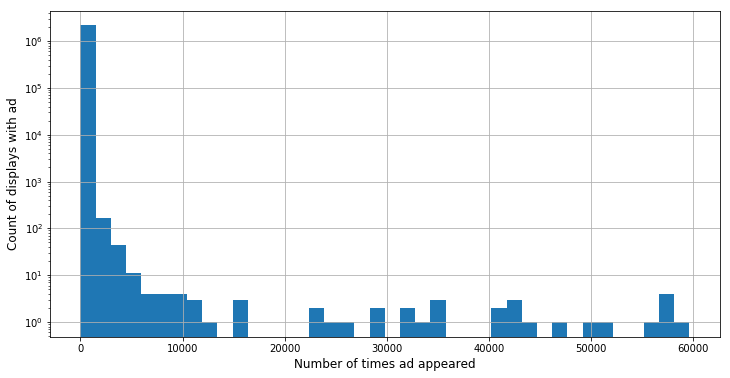

In [54]:
plt.figure(figsize=(12, 6))
plt.hist(ad_usage_train.values, bins=40, log=True)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('Count of displays with ad', fontsize=12)
plt.grid()
plt.show()

In [58]:
sizes_train = ad_usage_train[ad_usage_train < 20].value_counts()
sizes_train = sizes_train / np.sum(sizes_train)

bar = Bar("出现次数少于20次的商品数占比")

bar.add("", [str(i)+"次"for i in sizes_train.index.tolist()], np.around(sizes_train, decimals=5).tolist()\
        , is_label_show=True, is_datazoom_show=True, datazoom_range=[0, 40])
bar

In [61]:
category_count_train = train.groupby('category')['rating'].count()
sizes_category = category_count_train.value_counts()
sizes_category = sizes_category

bar = Bar("不同分类出现次数占比")

bar.add("", [str(i)+"次"for i in sorted(sizes_category.index.tolist())],\
        np.around(sizes_category, decimals=5).tolist(), is_label_show=True,\
        is_datazoom_show=True, datazoom_range=[0, 2])
bar

In [64]:
#时间特征
train.utcdate = pd.to_datetime(train.utcdate)
train = train.set_index('utcdate')

In [67]:
df_day.rating.value_counts()

utcdate     rating
2016-06-01  0          734010
            1           39889
2016-06-02  0         1319872
            1           42316
2016-06-03  0         1184380
            1           42745
2016-06-04  0         1123534
            1           38048
2016-06-05  0         1342884
            1           46646
2016-06-06  0          899592
            1           36608
2016-06-07  0         1076503
            1           41000
2016-06-08  0         1140123
            1           41514
2016-06-09  0         1001691
            1           39442
2016-06-10  0          664507
            1           31946
2016-06-11  0         1213500
            1           37060
2016-06-12  0         1551950
            1           50222
2016-06-13  0         1075251
            1           43583
2016-06-14  0          811473
            1          174428
Name: rating, dtype: int64

In [77]:
df_day = train.resample('D')
df_day_sum = df_day.rating.sum()
day_click = df_day.rating.value_counts().tolist()
## 统计点击率
day_click_rating = []
for i in range(int(len(day_click))):
    if i%2:
        continue
    day_click_rating.append(np.round(day_click[i+1]/(day_click[i+1]+day_click[i]),2))

In [78]:
bar = Bar("每天的点击情况")
bar.add("点击次数", [str(i)[:10] for i in df_day_sum.index.tolist()],\
        df_day_sum.tolist(), is_label_show=True,\
        is_datazoom_show=True, datazoom_range=[0, 30],mark_point=["max"])

In [79]:
bar = Bar("每天的点击情况")
bar.add("点击率", [str(i)[:10] for i in df_day_sum.index.tolist()],\
        day_click_rating, is_label_show=True,\
        is_datazoom_show=True, datazoom_range=[0, 30],mark_point=["max"])

In [82]:
df_hour = train.resample('H')
df_hour_sum = df_hour.rating.sum()

In [83]:
from pyecharts import Line
line = Line("每小时点击数统计")

line.add("点击数", [str(i)[5:13]+"点" for i in df_hour_sum.index.tolist()],\
         df_hour_sum.tolist(), is_smooth=True,is_datazoom_show=True,datazoom_range=[0, 10],\
         mark_line=["max", "average"])

# 测试集数据分析

In [3]:
uct_test = test

In [4]:
test.head()

,userid,offerid,countrycode,category,merchant,utcdate,rating
0,d581f697c19367969d3bff0ddd7491816969433ace2a1a...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-15 09:43:32.0,0
1,b6208e4f5c0ea1a5d0fe97e436d51fb5b8abf6f180ac37...,b75d6ee742849a6224bf49f55c56cb0f,de,100020213,26467f203f42913b6bc575fd4adc89ad66c5db082c8ab9...,2016-06-15 09:43:36.0,0
2,b4dfe41dcb584aee3f4b7c0364fb71816a5f8266f9b225...,3ba463bbdb2e24eac638c0d3d92776c2,de,100020213,10698b6475abd54c5c6d1724d6f51cb795234c23a23daf...,2016-06-15 09:44:02.0,0
3,d581f697c19367969d3bff0ddd7491816969433ace2a1a...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-15 09:44:04.0,0
4,351163eb97a830c6cb9b101f3f4ee1d8e87cee0c76a675...,b75d6ee742849a6224bf49f55c56cb0f,de,100020213,26467f203f42913b6bc575fd4adc89ad66c5db082c8ab9...,2016-06-15 09:44:12.0,0


In [25]:
# 用户分析
u_rate = test.groupby('userid').sum()['rating']
rate_count = u_rate.value_counts()
bar = Bar('不同点击次数的用户分布情况')
bar.add("用户数", [str(i)for i in rate_count.index.tolist()], rate_count.values.tolist(), mark_line=["average", "max"],
        is_datazoom_show = True,datazoom_range=[0, 5])

In [28]:
# 商品分析
o_rate = test.groupby('offerid').sum()['rating']
o_count = o_rate.value_counts()
bar = Bar('不同点击次数的商品分布情况')
bar.add('商品数',[str(i) for i in o_count.index.tolist()],o_count.values.tolist(),is_datazoom_show = True,datazoom_range = [0,5])

In [31]:
# 商品出现占比
o_show = test.groupby('offerid').count()['rating']
show_count = o_show.value_counts()

In [41]:
print('出现次数小于2的商品占比为:%s'%(o_show < 2).mean())

出现次数小于2的商品占比为:0.6761816477286156


In [46]:
print('一商品的出现次数最大的为:%d'% show_count.index.max())
print('一商品的出现次数最大的为:%d'% o_show.values.max())

一商品的出现次数最大的为:78008
一商品的出现次数最大的为:78008


In [49]:
#分类分析
print(len(test['category'].unique()))

267


In [52]:
c_rate = test.groupby('category').count()['rating']
c_count = c_rate.value_counts()
bar = Bar('不同类别商品的出现次数')
bar.add('类别数',[str(i) for i in c_count.index.tolist()],c_count.values.tolist(),is_datazoom_show = True,datazoom_range = [0,5])

In [54]:
test.utcdate = pd.to_datetime(test.utcdate)

In [58]:
test = test.set_index('utcdate')

In [59]:
d_test= test.resample('D')

In [65]:
#一天的点击次数
d_sum = d_test.sum()['rating']
bar = Bar("每天的点击情况")
bar.add("点击次数", [str(i)[:10] for i in d_sum.index.tolist()],\
        d_sum.tolist(), is_label_show=True,\
        is_datazoom_show=True, datazoom_range=[0, 30],mark_point=["max"])

In [71]:
#小时的点击次数
h_test= test.resample('H')
h_sum = h_test.sum()['rating']
bar = Bar("每小时的点击情况")
bar.add("点击次数", [str(i)[:13] for i in h_sum.index.tolist()],\
        h_sum.tolist(), is_label_show=True,\
        is_datazoom_show=True, datazoom_range=[0, 30],mark_point=["max"])

In [73]:
from pyecharts import Line
line = Line("每小时点击数统计")

line.add("点击数", [str(i)[5:13]+"点" for i in h_sum.index.tolist()],\
         h_sum.tolist(), is_smooth=True,is_datazoom_show=True,datazoom_range=[0, 10],\
         mark_line=["max", "average"])

In [4]:
#新用户统计
uct_test.utcdate = pd.to_datetime(uct_test.utcdate.map(lambda x:str(x)[:10])) # 去掉后面的时间，精确到天
user_test = uct_test.groupby('userid')

In [15]:
user_test['utcdate'].min() == user_test.utcdate.agg('min')

userid
0000dcabda4d6aeab9086b952140aa0b5966ce76bd367447ea5c56739f1363ab    True
0000e584bc9f22232cb991870889b500cdb683a4e1cf056c6c97ce70e0625301    True
0000fbfc92757df8a7727b0556fea5501b8c1439d16fc2305fa8c0bc15e394ea    True
000103699fa729d35d58aa743ceb8c3de12de7e410f66f7b91e68ed946fcb1d3    True
0001067d3fb68a8957a773e30b0eb3d08c67ba394544e182303958ebf3a41b10    True
00013967d5ea85a302c939e6f8e6a6d15477a098de2ea456aaedfad76b5f9430    True
00014f999e0a0d18e2731455271dbd59faae1bb176d024eb916243026f0690ab    True
000175628e84e28225b90a5473af1068ac0e78eaa81b2ea3080c98dbe2a597e8    True
000193911b6e17798ea648be1fadc686d8b0b16ff2a67a5b0be8cd2a9ec5f13d    True
0001b55c3d1d4b174774e2dc9c0ebbe327dcff8a5720ad048a917325782ad47e    True
0001f35881e5dcff8117bc22afc0db6273f0a4207584bd9acc892aa62818e474    True
00027875fa9c83f83567795f109d47cb94b89d4f0bee1edd38a64562fb16c876    True
00028d814598dc454eb11b5302e736873b18ea18a04eb9569535ecd1ea0d726f    True
0002a55d19dc51d0f925b1030ff0dba5baa633ebdb4f

In [10]:
d_user_count = user_test['utcdate'].min().value_counts()

In [13]:
bar = Bar("每天新增用户数")
bar.add("用户数", [str(i)[:10] for i in d_user_count.index.tolist()],\
        d_user_count.values.tolist(), is_label_show=True,\
        mark_point=["max"])

| 编号 | 特征 | 含义 |
| --- | --- | --- |
| 1 | userid_times | userid出现次数 |		
|2	|offerid_times  |	offerid出现次数|
|3	|category_times	|category出现次数
|4	|merchant_times	|merchant出现次数
|5	|category_encoding	|category的Encoding
|6	|merchant_encoding	|merchant的Encoding
|7	|week	|此浏览记录出现在星期几
|8	|hour	|此浏览记录出现在几点
|9	|is_new	|用户是否为新用户
|10	|pre_category	|用户产生这条记录前，是否产生过相同category的浏览记录
|11	|pre_merchant	|用户产生这条记录前，是否产生过相同merchant的浏览记录
|12	|pre_offerid	|用户产生这条记录前，是否产生过相同offerid的浏览记录
|13	|max_same_category	|用户全部浏览记录中，浏览次数最多的category和当前category是否相同
|14	|max_same_merchant	|用户全部浏览记录中，浏览次数最多的merchant和当前merchant是否相同

In [5]:
data_all = test

In [6]:
data_all.head()

,userid,offerid,countrycode,category,merchant,utcdate,rating
0,d581f697c19367969d3bff0ddd7491816969433ace2a1a...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-15 09:43:32.0,0
1,b6208e4f5c0ea1a5d0fe97e436d51fb5b8abf6f180ac37...,b75d6ee742849a6224bf49f55c56cb0f,de,100020213,26467f203f42913b6bc575fd4adc89ad66c5db082c8ab9...,2016-06-15 09:43:36.0,0
2,b4dfe41dcb584aee3f4b7c0364fb71816a5f8266f9b225...,3ba463bbdb2e24eac638c0d3d92776c2,de,100020213,10698b6475abd54c5c6d1724d6f51cb795234c23a23daf...,2016-06-15 09:44:02.0,0
3,d581f697c19367969d3bff0ddd7491816969433ace2a1a...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-15 09:44:04.0,0
4,351163eb97a830c6cb9b101f3f4ee1d8e87cee0c76a675...,b75d6ee742849a6224bf49f55c56cb0f,de,100020213,26467f203f42913b6bc575fd4adc89ad66c5db082c8ab9...,2016-06-15 09:44:12.0,0


In [7]:
data_all['userid_times'] = data_all['userid'].map(data_all.groupby('userid').count()['rating'])
data_all['offerid_times'] = data_all['offerid'].map(data_all.groupby('offerid').count()['rating'])
data_all['category_times'] = data_all['category'].map(data_all.groupby('category').count()['rating'])
data_all['merchant_times'] = data_all['merchant'].map(data_all.groupby('merchant').count()['rating'])

In [36]:
data_all.groupby('userid').count()['rating']

userid
0000dcabda4d6aeab9086b952140aa0b5966ce76bd367447ea5c56739f1363ab     1
0000e584bc9f22232cb991870889b500cdb683a4e1cf056c6c97ce70e0625301     1
0000fbfc92757df8a7727b0556fea5501b8c1439d16fc2305fa8c0bc15e394ea     1
000103699fa729d35d58aa743ceb8c3de12de7e410f66f7b91e68ed946fcb1d3     2
0001067d3fb68a8957a773e30b0eb3d08c67ba394544e182303958ebf3a41b10     1
00013967d5ea85a302c939e6f8e6a6d15477a098de2ea456aaedfad76b5f9430     1
00014f999e0a0d18e2731455271dbd59faae1bb176d024eb916243026f0690ab     1
000175628e84e28225b90a5473af1068ac0e78eaa81b2ea3080c98dbe2a597e8     6
000193911b6e17798ea648be1fadc686d8b0b16ff2a67a5b0be8cd2a9ec5f13d    13
0001b55c3d1d4b174774e2dc9c0ebbe327dcff8a5720ad048a917325782ad47e     1
0001f35881e5dcff8117bc22afc0db6273f0a4207584bd9acc892aa62818e474     1
00027875fa9c83f83567795f109d47cb94b89d4f0bee1edd38a64562fb16c876     2
00028d814598dc454eb11b5302e736873b18ea18a04eb9569535ecd1ea0d726f     1
0002a55d19dc51d0f925b1030ff0dba5baa633ebdb4ffdb48b5865ed7acc6b6e     1

In [49]:
data_all.head()

,userid,offerid,countrycode,category,merchant,utcdate,rating,userid_times,offerid_times,category_times,merchant_times
0,d581f697c19367969d3bff0ddd7491816969433ace2a1a...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-15 09:43:32.0,0,2880,74205,439328,79987
1,b6208e4f5c0ea1a5d0fe97e436d51fb5b8abf6f180ac37...,b75d6ee742849a6224bf49f55c56cb0f,de,100020213,26467f203f42913b6bc575fd4adc89ad66c5db082c8ab9...,2016-06-15 09:43:36.0,0,1400,24092,536005,26208
2,b4dfe41dcb584aee3f4b7c0364fb71816a5f8266f9b225...,3ba463bbdb2e24eac638c0d3d92776c2,de,100020213,10698b6475abd54c5c6d1724d6f51cb795234c23a23daf...,2016-06-15 09:44:02.0,0,4556,28504,536005,48481
3,d581f697c19367969d3bff0ddd7491816969433ace2a1a...,be83df9772ec47fd210b28091138ff11,de,125801,4740b6c83b6e12e423297493f234323ffd1c991f3d4496...,2016-06-15 09:44:04.0,0,2880,74205,439328,79987
4,351163eb97a830c6cb9b101f3f4ee1d8e87cee0c76a675...,b75d6ee742849a6224bf49f55c56cb0f,de,100020213,26467f203f42913b6bc575fd4adc89ad66c5db082c8ab9...,2016-06-15 09:44:12.0,0,1550,24092,536005,26208


In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
for i in ['userid','offerid','category','merchant']:
    le = LabelEncoder()
    le.fit(data_all[i])
    data_all[i] = le.transform(data_all[i]) 

In [52]:
data_all.head()

,userid,offerid,countrycode,category,merchant,utcdate,rating,userid_times,offerid_times,category_times,merchant_times
0,232085,283423,de,54,213,2016-06-15 09:43:32.0,0,2880,74205,439328,79987
1,197852,272736,de,150,123,2016-06-15 09:43:36.0,0,1400,24092,536005,26208
2,196486,88681,de,150,50,2016-06-15 09:44:02.0,0,4556,28504,536005,48481
3,232085,283423,de,54,213,2016-06-15 09:44:04.0,0,2880,74205,439328,79987
4,57550,272736,de,150,123,2016-06-15 09:44:12.0,0,1550,24092,536005,26208


In [10]:
data_all['utcdate'] = pd.to_datetime(data_all['utcdate'])

In [11]:
del data_all['countrycode']
data_all['week'] = data_all['utcdate'].map(lambda x:x.weekday())

In [55]:
data_all.head()

,userid,offerid,category,merchant,utcdate,rating,userid_times,offerid_times,category_times,merchant_times,week
0,232085,283423,54,213,2016-06-15 09:43:32,0,2880,74205,439328,79987,2
1,197852,272736,150,123,2016-06-15 09:43:36,0,1400,24092,536005,26208,2
2,196486,88681,150,50,2016-06-15 09:44:02,0,4556,28504,536005,48481,2
3,232085,283423,54,213,2016-06-15 09:44:04,0,2880,74205,439328,79987,2
4,57550,272736,150,123,2016-06-15 09:44:12,0,1550,24092,536005,26208,2


In [12]:
data_all['hour'] = data_all['utcdate'].map(lambda x:x.hour)
data_all['day'] = data_all['utcdate'].map(lambda x:x.day)

In [11]:
data_all.head()

,userid,offerid,category,merchant,utcdate,rating,userid_times,offerid_times,category_times,merchant_times,week,hour,day
0,232085,283423,54,213,2016-06-15 09:43:32,0,2880,74205,439328,79987,2,9,15
1,197852,272736,150,123,2016-06-15 09:43:36,0,1400,24092,536005,26208,2,9,15
2,196486,88681,150,50,2016-06-15 09:44:02,0,4556,28504,536005,48481,2,9,15
3,232085,283423,54,213,2016-06-15 09:44:04,0,2880,74205,439328,79987,2,9,15
4,57550,272736,150,123,2016-06-15 09:44:12,0,1550,24092,536005,26208,2,9,15


In [13]:
max_category = data_all.category_times.max()
max_merchant = data_all.merchant_times.max()
print(max_category)
print(max_merchant)

536005
152428


In [14]:
data_all['max_same_category'] = data_all['category_times'].map(lambda x:x==max_category and 1 or 0)
data_all['max_same_merchant'] = data_all['merchant_times'].map(lambda x:x==max_merchant and 1 or 0)

In [24]:
data_all.head()

,userid,offerid,category,merchant,utcdate,rating,userid_times,offerid_times,category_times,merchant_times,week,hour,day,max_same_category,max_same_merchant
0,232085,283423,54,213,2016-06-15 09:43:32,0,2880,74205,439328,79987,2,9,15,0,0
1,197852,272736,150,123,2016-06-15 09:43:36,0,1400,24092,536005,26208,2,9,15,1,0
2,196486,88681,150,50,2016-06-15 09:44:02,0,4556,28504,536005,48481,2,9,15,1,0
3,232085,283423,54,213,2016-06-15 09:44:04,0,2880,74205,439328,79987,2,9,15,0,0
4,57550,272736,150,123,2016-06-15 09:44:12,0,1550,24092,536005,26208,2,9,15,1,0


In [15]:
def find_pre(n):
    pre_dic = {}
    res = []
    for i in n.values:
        if i in pre_dic:
            res.append(pre_dic[i])
            pre_dic[i] = pre_dic[i]+1
        else:
            res.append(0)
            pre_dic[i] = 1
    return np.array(res)

def lowest(ss):
        reslen = len(ss.values)
        res = np.zeros(reslen)
        res[ss == ss.min()] = 1
        return res

In [16]:
data_all['pre_category'] = data_all.groupby('userid')['category'].transform(find_pre)#group 与 transform 连用
data_all['pre_merchant'] = data_all.groupby('userid')['merchant'].transform(find_pre)
data_all['pre_offerid'] = data_all.groupby('userid')['offerid'].transform(find_pre)
data_all['is_new'] = data_all.groupby('userid')['utcdate'].transform(lowest)

In [17]:
data_all.head()

,userid,offerid,category,merchant,utcdate,rating,userid_times,offerid_times,category_times,merchant_times,week,hour,day,max_same_category,max_same_merchant,pre_category,pre_merchant,pre_offerid,is_new
0,232085,283423,54,213,2016-06-15 09:43:32,0,2880,74205,439328,79987,2,9,15,0,0,0,0,0,0.0
1,197852,272736,150,123,2016-06-15 09:43:36,0,1400,24092,536005,26208,2,9,15,1,0,0,0,0,0.0
2,196486,88681,150,50,2016-06-15 09:44:02,0,4556,28504,536005,48481,2,9,15,1,0,0,0,0,0.0
3,232085,283423,54,213,2016-06-15 09:44:04,0,2880,74205,439328,79987,2,9,15,0,0,1,1,1,0.0
4,57550,272736,150,123,2016-06-15 09:44:12,0,1550,24092,536005,26208,2,9,15,1,0,0,0,0,0.0


In [18]:
data_all.to_csv('./test_after_features_engineering.csv')

In [19]:
len(data_all)

1919561

## 转为ffm格式

In [23]:
del data_all['utcdate']
categorical_features = ['userid','offerid','category','merchant','is_new','max_same_category','max_same_merchant']

In [24]:
data_all.head()

,userid,offerid,category,merchant,rating,userid_times,offerid_times,category_times,merchant_times,week,hour,day,max_same_category,max_same_merchant,pre_category,pre_merchant,pre_offerid,is_new
0,232085,283423,54,213,0,2880,74205,439328,79987,2,9,15,0,0,0,0,0,0.0
1,197852,272736,150,123,0,1400,24092,536005,26208,2,9,15,1,0,0,0,0,0.0
2,196486,88681,150,50,0,4556,28504,536005,48481,2,9,15,1,0,0,0,0,0.0
3,232085,283423,54,213,0,2880,74205,439328,79987,2,9,15,0,0,1,1,1,0.0
4,57550,272736,150,123,0,1550,24092,536005,26208,2,9,15,1,0,0,0,0,0.0


In [31]:
raw_ffm_data = data_all
for col in categorical_features:
    raw_ffm_data[col] = raw_ffm_data[col].astype(str)


In [38]:
len(raw_ffm_data.columns)

18

In [30]:
raw_ffm_data.head()

,userid,offerid,category,merchant,rating,userid_times,offerid_times,category_times,merchant_times,week,hour,day,max_same_category,max_same_merchant,pre_category,pre_merchant,pre_offerid,is_new
0,232085,283423,54,213,0,2880,74205,439328,79987,2,9,15,0,0,0,0,0,0.0
1,197852,272736,150,123,0,1400,24092,536005,26208,2,9,15,1,0,0,0,0,0.0
2,196486,88681,150,50,0,4556,28504,536005,48481,2,9,15,1,0,0,0,0,0.0
3,232085,283423,54,213,0,2880,74205,439328,79987,2,9,15,0,0,1,1,1,0.0
4,57550,272736,150,123,0,1550,24092,536005,26208,2,9,15,1,0,0,0,0,0.0


In [25]:
from sklearn.preprocessing import scale

# 归一化
def minmaxScale(df):
    min_data = df.min()
    max_data = df.max()
    dev_data = max_data-min_data
    return df.map(lambda x:(x-min_data)/dev_data)
    
def FFMFormatPandas(pd_data):
    col_list = pd_data.columns
    field_index = dict(zip(col_list, range(len(col_list))))
    base_index = 0
    for col in pd_data.columns:
        if pd_data[col].dtype == 'object':
            vals = pd_data[col].unique()
            index_dict = dict(zip(vals,range(len(vals))))
            pd_data[col] = pd_data[col].map(lambda x: (field_index[col],base_index+index_dict[x],1))#focus on index_dict[x]
            base_index+=len(vals)
        else :
            pd_data[col] = np.round(minmaxScale(pd_data[col]),6)
            vals = pd_data[col].unique()
            index_dict = dict(zip(vals,range(len(vals))))
            pd_data[col] = pd_data[col].map(lambda x: (field_index[col],base_index,x))#focus on x
            base_index+=1
        
    return pd_data.values

In [32]:
%%time
data_ffm =FFMFormatPandas(raw_ffm_data.drop(['rating','day'],1))
data_ffm_y = raw_ffm_data.rating.tolist()

Wall time: 25.2 s


In [35]:
np.shape(data_ffm)

(1919561, 16)

In [43]:
df_ffm = pd.DataFrame(data_ffm,columns=['userid','offerid','category','merchant','userid_times','offerid_times','category_times','merchant_times','week','hour','max_same_category','max_same_merchant','pre_category','pre_merchant','pre_offerid','is_new'])

In [44]:
df_ffm.head()

,userid,offerid,category,merchant,userid_times,offerid_times,category_times,merchant_times,week,hour,max_same_category,max_same_merchant,pre_category,pre_merchant,pre_offerid,is_new
0,"(0, 0, 1)","(1, 278293, 1)","(2, 659096, 1)","(3, 659363, 1)","(4, 660101, 0.031124)","(5, 660102, 0.951248)","(6, 660103, 0.819634)","(7, 660104, 0.52475)","(8, 660105, 0.333333)","(9, 660106, 0.391304)","(10, 660107, 1)","(11, 660109, 1)","(12, 660111, 0.0)","(13, 660112, 0.0)","(14, 660113, 0.0)","(15, 660114, 1)"
1,"(0, 1, 1)","(1, 278294, 1)","(2, 659097, 1)","(3, 659364, 1)","(4, 660101, 0.015124)","(5, 660102, 0.308831)","(6, 660103, 1.0)","(7, 660104, 0.171931)","(8, 660105, 0.333333)","(9, 660106, 0.391304)","(10, 660108, 1)","(11, 660109, 1)","(12, 660111, 0.0)","(13, 660112, 0.0)","(14, 660113, 0.0)","(15, 660114, 1)"
2,"(0, 2, 1)","(1, 278295, 1)","(2, 659097, 1)","(3, 659365, 1)","(4, 660101, 0.049243)","(5, 660102, 0.36539)","(6, 660103, 1.0)","(7, 660104, 0.318054)","(8, 660105, 0.333333)","(9, 660106, 0.391304)","(10, 660108, 1)","(11, 660109, 1)","(12, 660111, 0.0)","(13, 660112, 0.0)","(14, 660113, 0.0)","(15, 660114, 1)"
3,"(0, 0, 1)","(1, 278293, 1)","(2, 659096, 1)","(3, 659363, 1)","(4, 660101, 0.031124)","(5, 660102, 0.951248)","(6, 660103, 0.819634)","(7, 660104, 0.52475)","(8, 660105, 0.333333)","(9, 660106, 0.391304)","(10, 660107, 1)","(11, 660109, 1)","(12, 660111, 0.000101)","(13, 660112, 5.7e-05)","(14, 660113, 0.000631)","(15, 660114, 1)"
4,"(0, 3, 1)","(1, 278294, 1)","(2, 659097, 1)","(3, 659364, 1)","(4, 660101, 0.016746)","(5, 660102, 0.308831)","(6, 660103, 1.0)","(7, 660104, 0.171931)","(8, 660105, 0.333333)","(9, 660106, 0.391304)","(10, 660108, 1)","(11, 660109, 1)","(12, 660111, 0.0)","(13, 660112, 0.0)","(14, 660113, 0.0)","(15, 660114, 1)"


In [46]:
df_ffm.to_csv('test_toffm.csv')

In [45]:
raw_ffm_data.head()

,userid,offerid,category,merchant,rating,userid_times,offerid_times,category_times,merchant_times,week,hour,day,max_same_category,max_same_merchant,pre_category,pre_merchant,pre_offerid,is_new
0,232085,283423,54,213,0,2880,74205,439328,79987,2,9,15,0,0,0,0,0,0.0
1,197852,272736,150,123,0,1400,24092,536005,26208,2,9,15,1,0,0,0,0,0.0
2,196486,88681,150,50,0,4556,28504,536005,48481,2,9,15,1,0,0,0,0,0.0
3,232085,283423,54,213,0,2880,74205,439328,79987,2,9,15,0,0,1,1,1,0.0
4,57550,272736,150,123,0,1550,24092,536005,26208,2,9,15,1,0,0,0,0,0.0
